In [52]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
# tf.keras.backend.set_floatx(
#     'float32'
# )
import numpy as np
import seaborn as sns; 
tfd = tf.contrib.distributions
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from tqdm import tqdm_notebook as tqdm
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm

print(tf.__version__)

1.15.0


In [53]:
tol = 1e-35
bs = 500
K = 3
do = 0.8

def ratios_critic(x, prob = 1, reuse=False):
    with tf.variable_scope('critic') as scope:
      if reuse:
        scope.reuse_variables()
      x = tf.expand_dims(x,1)
      h = slim.fully_connected(x, 20, activation_fn=tf.nn.softplus)
      h = tf.nn.dropout(h,prob)
      h = slim.fully_connected(h, 10, activation_fn=tf.nn.softplus)
      h = tf.nn.dropout(h,prob)
      log_d = slim.fully_connected(h, K, activation_fn=None)
    return tf.squeeze(log_d)


In [89]:
tf.reset_default_graph()
tf.random.set_random_seed(40)

mu_1 = 0.
mu_2 = 4.
mu_3 = 4.
lam = tf.placeholder('float',1)
p = tfd.Normal(loc=mu_1, scale=.1)
q = tfd.Normal(loc=mu_2, scale=.1)
base = tfp.distributions.Cauchy(loc=mu_3, scale=2.)


samples = base.sample([bs]) 
p_samples = p.sample([bs]) 
q_samples = q.sample([bs])
m_samples = samples
# m_samples = samples + (p_samples+q_samples)/2.
m_samples2 = m_samples# samples[bs:]

#Ratio by log of prob evaluated at samples from base
log_ratio_p_q = p.log_prob(m_samples) - q.log_prob(m_samples)
#KL from CoB
kld = tf.reduce_mean(log_ratio_p_q) 


In [90]:
# Build 2 Discriminator Networks (one from noise input, one from generated samples)

disc_real = ratios_critic(p_samples, do)
disc_fake = ratios_critic(q_samples, do,reuse=True)
disc_m = ratios_critic(m_samples, do,reuse=True)
# disc_m_gen = ratios_critic(m_samples2, do,reuse=True)

# Build Loss
# lab = np.eye(K)
# a = np.tile(lab[0],bs)
# b = np.tile(lab[1],bs)
# c = np.tile(lab[2],bs)

a = np.tile([1,0,0],bs)
b = np.tile([0,1,0],bs)
c = np.tile([0,0,1],bs)

label_a = tf.reshape(a,[bs,K])
label_b = tf.reshape(b,[bs,K])
label_c = tf.reshape(c,[bs,K])


disc_loss_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_real, labels=label_a))
disc_loss_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_fake, labels=label_b))
disc_loss_3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m, labels=label_c))
# disc_loss_4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m_gen, labels=label_c))

dloss = disc_loss_1 + disc_loss_2 + 1*disc_loss_3 #+ 0.5*disc_loss_4 

# Define CoB DRE

log_r_p_m = ratios_critic(m_samples, reuse=True) 
log_r_p_from_m_direct = log_r_p_m 

t_vars = tf.trainable_variables()
c_vars = [var for var in t_vars if 'critic' in var.name]

c_optim = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(dloss, var_list=t_vars)

init = tf.global_variables_initializer()
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)


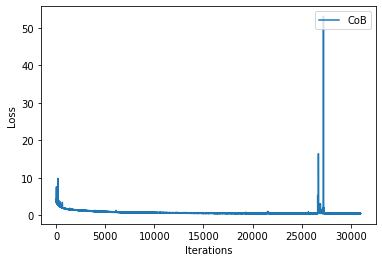

In [91]:
# Training
loss2 = []
pbar = (range(0,31000))
for i in tqdm(pbar):
    # Train
    feed_dict = {}
    l2,_ = sess.run([dloss, c_optim],feed_dict=feed_dict)
    loss2.append(l2)

fig = plt.figure()
ax = plt.axes()
plt.plot(loss2, label='CoB')
ax.set_xlabel('Iterations' )
ax.set_ylabel('Loss')
plt.legend(loc='upper right')

(-5.0, 5.0)

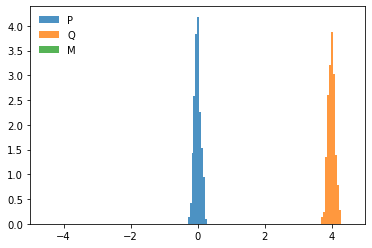

In [92]:
# Sampling
kl_ratio_store=[]
log_ratio_store=[]
log_r_p_from_m_direct_store=[]


feed_dict = feed_dict
kl_ratio, p_s, q_s, d_s, m_s, lpq, lpq_from_cob_dre_direct= sess.run([kld,
                                                                            p_samples, q_samples, samples, m_samples,
                                                                            log_ratio_p_q,  log_r_p_from_m_direct],
                                                                          feed_dict=feed_dict)
kl_ratio_store.append(kl_ratio)
log_ratio_store.append(lpq)
log_r_p_from_m_direct_store.append(lpq_from_cob_dre_direct)
    
fig, ax = plt.subplots(1, 1)
ax.hist(p_s, density=True, histtype='stepfilled', alpha=0.8, label='P')
ax.hist(q_s, density=True, histtype='stepfilled', alpha=0.8, label='Q')
# ax.hist(d_s, density=True, histtype='stepfilled', alpha=0.8, label='M')
ax.hist(m_s, density=True, histtype='stepfilled', alpha=0.8, label='M')
ax.legend(loc='best', frameon=False)
plt.xlim(-5,5)
# plt.ylim(-400,800)

(-400.0, 1000.0)

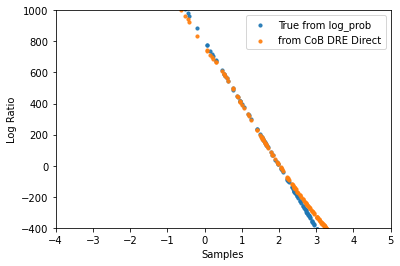

In [93]:
xs = m_s
plt.scatter(xs,log_ratio_store[0],label='True from log_prob',alpha=0.9,s=10.)
plt.scatter(xs,log_r_p_from_m_direct_store[-1][:,0]-log_r_p_from_m_direct_store[-1][:,1],label='from CoB DRE Direct',alpha=0.9,s=10.)

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xlim(-4,5)
plt.ylim(-400,1000)

(-1000.0, 1000.0)

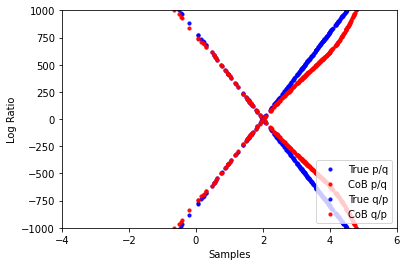

In [94]:
plt.scatter(xs,log_ratio_store[0],label='True p/q',alpha=0.9,s=10.,c='b')
plt.scatter(xs,log_r_p_from_m_direct_store[-1][:,0]-log_r_p_from_m_direct_store[-1][:,1],label='CoB p/q',alpha=0.9,s=10.,c='r')
plt.scatter(xs,-log_ratio_store[0],label='True q/p',alpha=0.9,s=10.,c='b')
plt.scatter(xs,log_r_p_from_m_direct_store[-1][:,1]-log_r_p_from_m_direct_store[-1][:,0],label='CoB q/p',alpha=0.9,s=10.,c='r')

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='lower right')
plt.xlim(-4,6)
plt.ylim(-1000,1000)

(-600.0, 400.0)

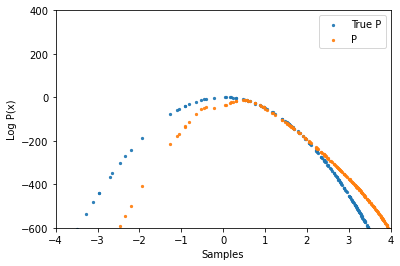

In [95]:
rat = log_r_p_from_m_direct_store[-1][:,0]-log_r_p_from_m_direct_store[-1][:,1]
d = [np.squeeze(norm.logpdf(x,mu_2,0.1)) for x in xs]
b = [np.squeeze(norm.logpdf(x,mu_1,0.1)) for x in xs]

plt.scatter(xs,b,label='True P',alpha=0.9,s=5.)
plt.scatter(xs,rat+d,label='P',alpha=0.9,s=5.)

plt.xlabel("Samples")
plt.ylabel("Log P(x)")
plt.legend(loc='upper right')
plt.xlim(-4.,4)
plt.ylim(-600,400)